# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [191]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [192]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

#### 5.0.1 Cоотношение ушедших и лояльных клиентов

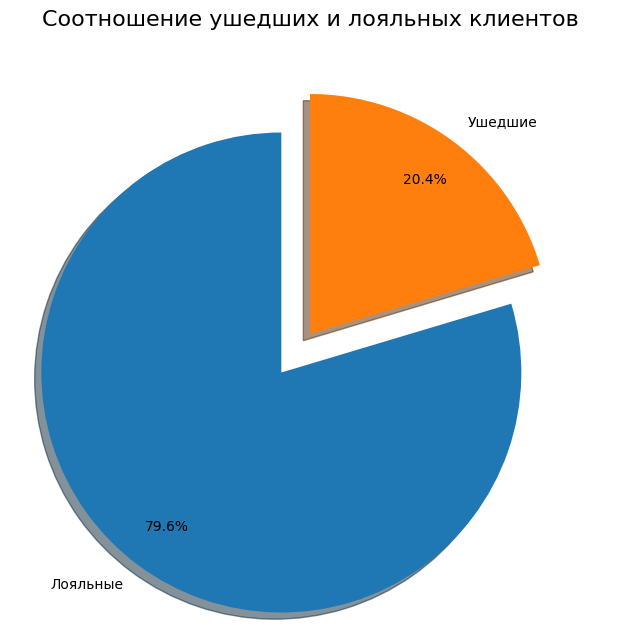

In [193]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))
client_count = churn_data['Exited'].value_counts().sort_values(ascending=False) # Сумируем количество ушедших и лояльных клиентов
pie = ax.pie(
    client_count,
    labels=['Лояльные','Ушедшие'], # Подписи для легенды
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8, # относительное расстояние вдоль радиуса, на котором будет размещен текст, сгенерированный с помощью autopct. 
    shadow=True,
    labeldistance=1.1, # определяет расстояние между центром каждой доли и началом текстовой метки на круговой диаграмме
    counterclock=True, # логическое значение, определяющее направление вращения секторов (по умолчанию True - против часовой стрелки).
    explode = [0.2,0] # массив чисел, определяющих выдвижение секторов из центра диаграммы.
)
title = ax.set_title('Соотношение ушедших и лояльных клиентов', fontsize=16)
plt.show(pie)

#### 5.0.2 График, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов

In [194]:
import plotly.express as px
mask = churn_data['Balance'] > 2500 # баланс на счетах клиента в банке больше 2500
filtered = churn_data[mask] # отбираем всех клиентов, у которых баланс больше 2500

fig = px.histogram(
    filtered,
    x = 'Balance', # количественный признак
    marginal = 'box', # дополнительный график: boxplot
    labels = {"Balance": "Баланс"},
    title = 'Распределение баланса пользователей, у которых на счету больше 2 500 долларов'
) 
fig.update_layout(showlegend=False)
fig.show()

#### 5.0.3 Распределение баланса клиента в разрезе признака оттока

In [195]:
churn_data['client_status'] = churn_data['Exited'] .apply(lambda x: 'loyal' if x == 0 else 'departed') # Делаем признак более явным :)
fig = px.histogram(
    churn_data,
    x = 'Balance', # количественный признак
    color = 'client_status', # категориальный признак
    marginal = 'box', # дополнительный график: boxplot
    labels = {"Balance": "Баланс", "client_status": "Тип клиентов"},
    title = 'Распределение баланса пользователей лояльных и ушедших клиентов'
) 
#fig.update_layout(showlegend=False)
fig.show()

#### 5.0.4 Распределение возраста в разрезе признака оттока

In [196]:
fig = px.histogram(
    churn_data,
    x = 'Age', # количественный признак
    color = 'client_status', # категориальный признак
    marginal = 'box', # дополнительный график: boxplot
    labels = {"Age": "Возраст", "client_status": "Тип клиентов"},
    title = 'Возраст лояльных и ушедших клиентов',
    histfunc = 'count'
) 
#fig.update_layout(showlegend=False)
fig.show()

#### 5.0.5 Доля ушедших в разрезе пола клиентов

In [197]:
grouped = churn_data.groupby('Gender')['Exited'].mean()
data = dict( 
    labels=['Ж-ушедшие','М-ушедшие'],
    values=grouped
)

# Create a pie chart using Plotly Express
fig = px.pie(
    data, 
    values='values', 
    names='labels', 
    title='Доля ушедших в разрезе пола клиентов',
)

# Show the pie chart
fig.show()

#### 5.0.6 Отток клиентов в зависимости от числа приобретённых у банка услуг

In [198]:
pivot = churn_data.pivot_table(
    values='Balance',
    index='client_status',
    columns='NumOfProducts',
    aggfunc=['count'],
    fill_value=0
)

print(pivot)
mask = churn_data['Exited'] == 1
grouped1 = churn_data[mask].groupby('NumOfProducts')['client_status'].count()
grouped0 = churn_data[-mask].groupby('NumOfProducts')['client_status'].count()
df = pd.concat([grouped1, grouped0], axis=1,keys=['Ушедшие', 'Лояльные'])

fig=px.bar(df, barmode='group', labels={'NumOfProducts': 'Количество приобретенных услуг', 'value': 'количество клиентов'}, title='Отток клиентов в зависимости от числа приобретённых у банка услуг')
fig.update_layout(legend_title='статус лояльности')
fig.show()

              count               
NumOfProducts     1     2    3   4
client_status                     
departed       1409   348  220  60
loyal          3675  4242   46   0


#### 5.0.7 Доля ушедших в разрезе статуса активного клиента банка

In [199]:
grouped = churn_data.groupby('IsActiveMember')['Exited'].mean()
data = dict( 
    labels=['Не активный клиент','Активный клиент'],
    values=grouped
)

# Create a pie chart using Plotly Express
fig = px.pie(
    data, 
    values='values', 
    names='labels', 
    title='Доля ушедших в разрезе статуса активного клиента банка',
)

# Show the pie chart
fig.show()

#### 5.0.8 Доля ушедших клиентов на карте мира

In [200]:
grouped = churn_data.groupby('Geography')['Exited'].mean().reset_index()
grouped['Exited']  = grouped['Exited'] * 100
grouped.info()
display(grouped)

fig = px.choropleth(
    grouped, 
    locations="Geography", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="Exited", #от чего зависит цвет
    projection='equirectangular', 
    title='Доля ушедших клиентов на карте мира',
    labels={'Exited': 'Доля ушедших'}
)
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Geography  3 non-null      object 
 1   Exited     3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 176.0+ bytes


,Geography,Exited
0,France,16.154767
1,Germany,32.443204
2,Spain,16.673395


---

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [201]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 15)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [202]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client_status
7,376,Female,29,4,115046.74,4,1,0,119346.88,1,departed
15,616,Male,45,3,143129.41,2,0,1,64327.26,0,loyal
16,653,Male,58,1,132602.88,1,1,0,5097.67,1,departed
26,756,Male,36,2,136815.64,1,1,1,170041.95,0,loyal
28,574,Female,43,3,141349.43,1,1,1,100187.43,0,loyal


Проверим, что в наших данных нет пропусков:

In [203]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
client_status      0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [204]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
client_status        0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### 5.1.1 Создаем новые признаки

In [205]:
# Создаем новый признак `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

# Создаем новый признак `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

# Создаем новый признак `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

#### 5.1.2 Кодируем категориальных признаков в числовые бинарные столбцы

In [206]:
churn_data = pd.get_dummies(churn_data, drop_first=True)
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male,client_status_loyal
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,False,False
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,True,True
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,True,False
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,True,True
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,False,True


In [207]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Age                  2509 non-null   int64  
 2   Tenure               2509 non-null   int64  
 3   Balance              2509 non-null   float64
 4   NumOfProducts        2509 non-null   int64  
 5   HasCrCard            2509 non-null   int64  
 6   IsActiveMember       2509 non-null   int64  
 7   EstimatedSalary      2509 non-null   float64
 8   Exited               2509 non-null   int64  
 9   BalanceSalaryRatio   2509 non-null   float64
 10  TenureByAge          2509 non-null   float64
 11  CreditScoreGivenAge  2509 non-null   float64
 12  Gender_Male          2509 non-null   bool   
 13  client_status_loyal  2509 non-null   bool   
dtypes: bool(2), float64(5), int64(7)
memory usage: 259.7 KB


In [208]:
# Переводим признаки из bool в int
churn_data['Gender_Male'] = churn_data['Gender_Male'].astype(int)
churn_data['client_status_loyal'] = churn_data['client_status_loyal'].astype(int)

# Проверяем новые типы данных
print(churn_data.dtypes)

CreditScore              int64
Age                      int64
Tenure                   int64
Balance                float64
NumOfProducts            int64
HasCrCard                int64
IsActiveMember           int64
EstimatedSalary        float64
Exited                   int64
BalanceSalaryRatio     float64
TenureByAge            float64
CreditScoreGivenAge    float64
Gender_Male              int32
client_status_loyal      int32
dtype: object


#### 5.1.4 Расчёта основных статистических характеристик полученных признаков

Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

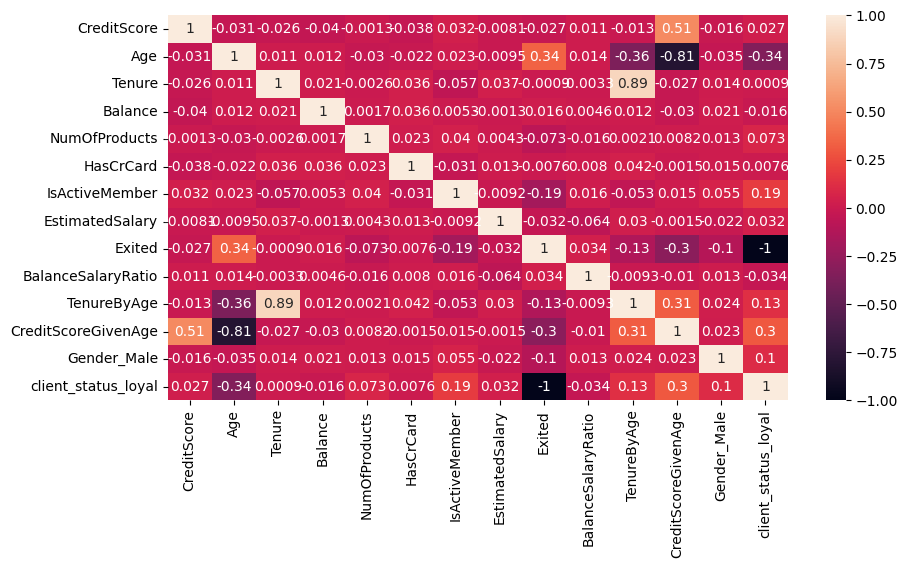

In [209]:
plt.figure(figsize = (10, 5))
sns.heatmap(churn_data.corr(numeric_only=True), annot = True);

Удаляем признаки 'Age', 'Tenure', 'client_status_loyal'

In [210]:
churn_data = churn_data.drop(['Age', 'Tenure', 'client_status_loyal'],axis=1)

In [211]:
# Рассчитываем статистики для числовых признаков
churn_data.describe()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
count,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

In [212]:
num_features = ['CreditScore',
 'Balance',
 'EstimatedSalary',
 'BalanceSalaryRatio',
 'TenureByAge',
 'CreditScoreGivenAge']

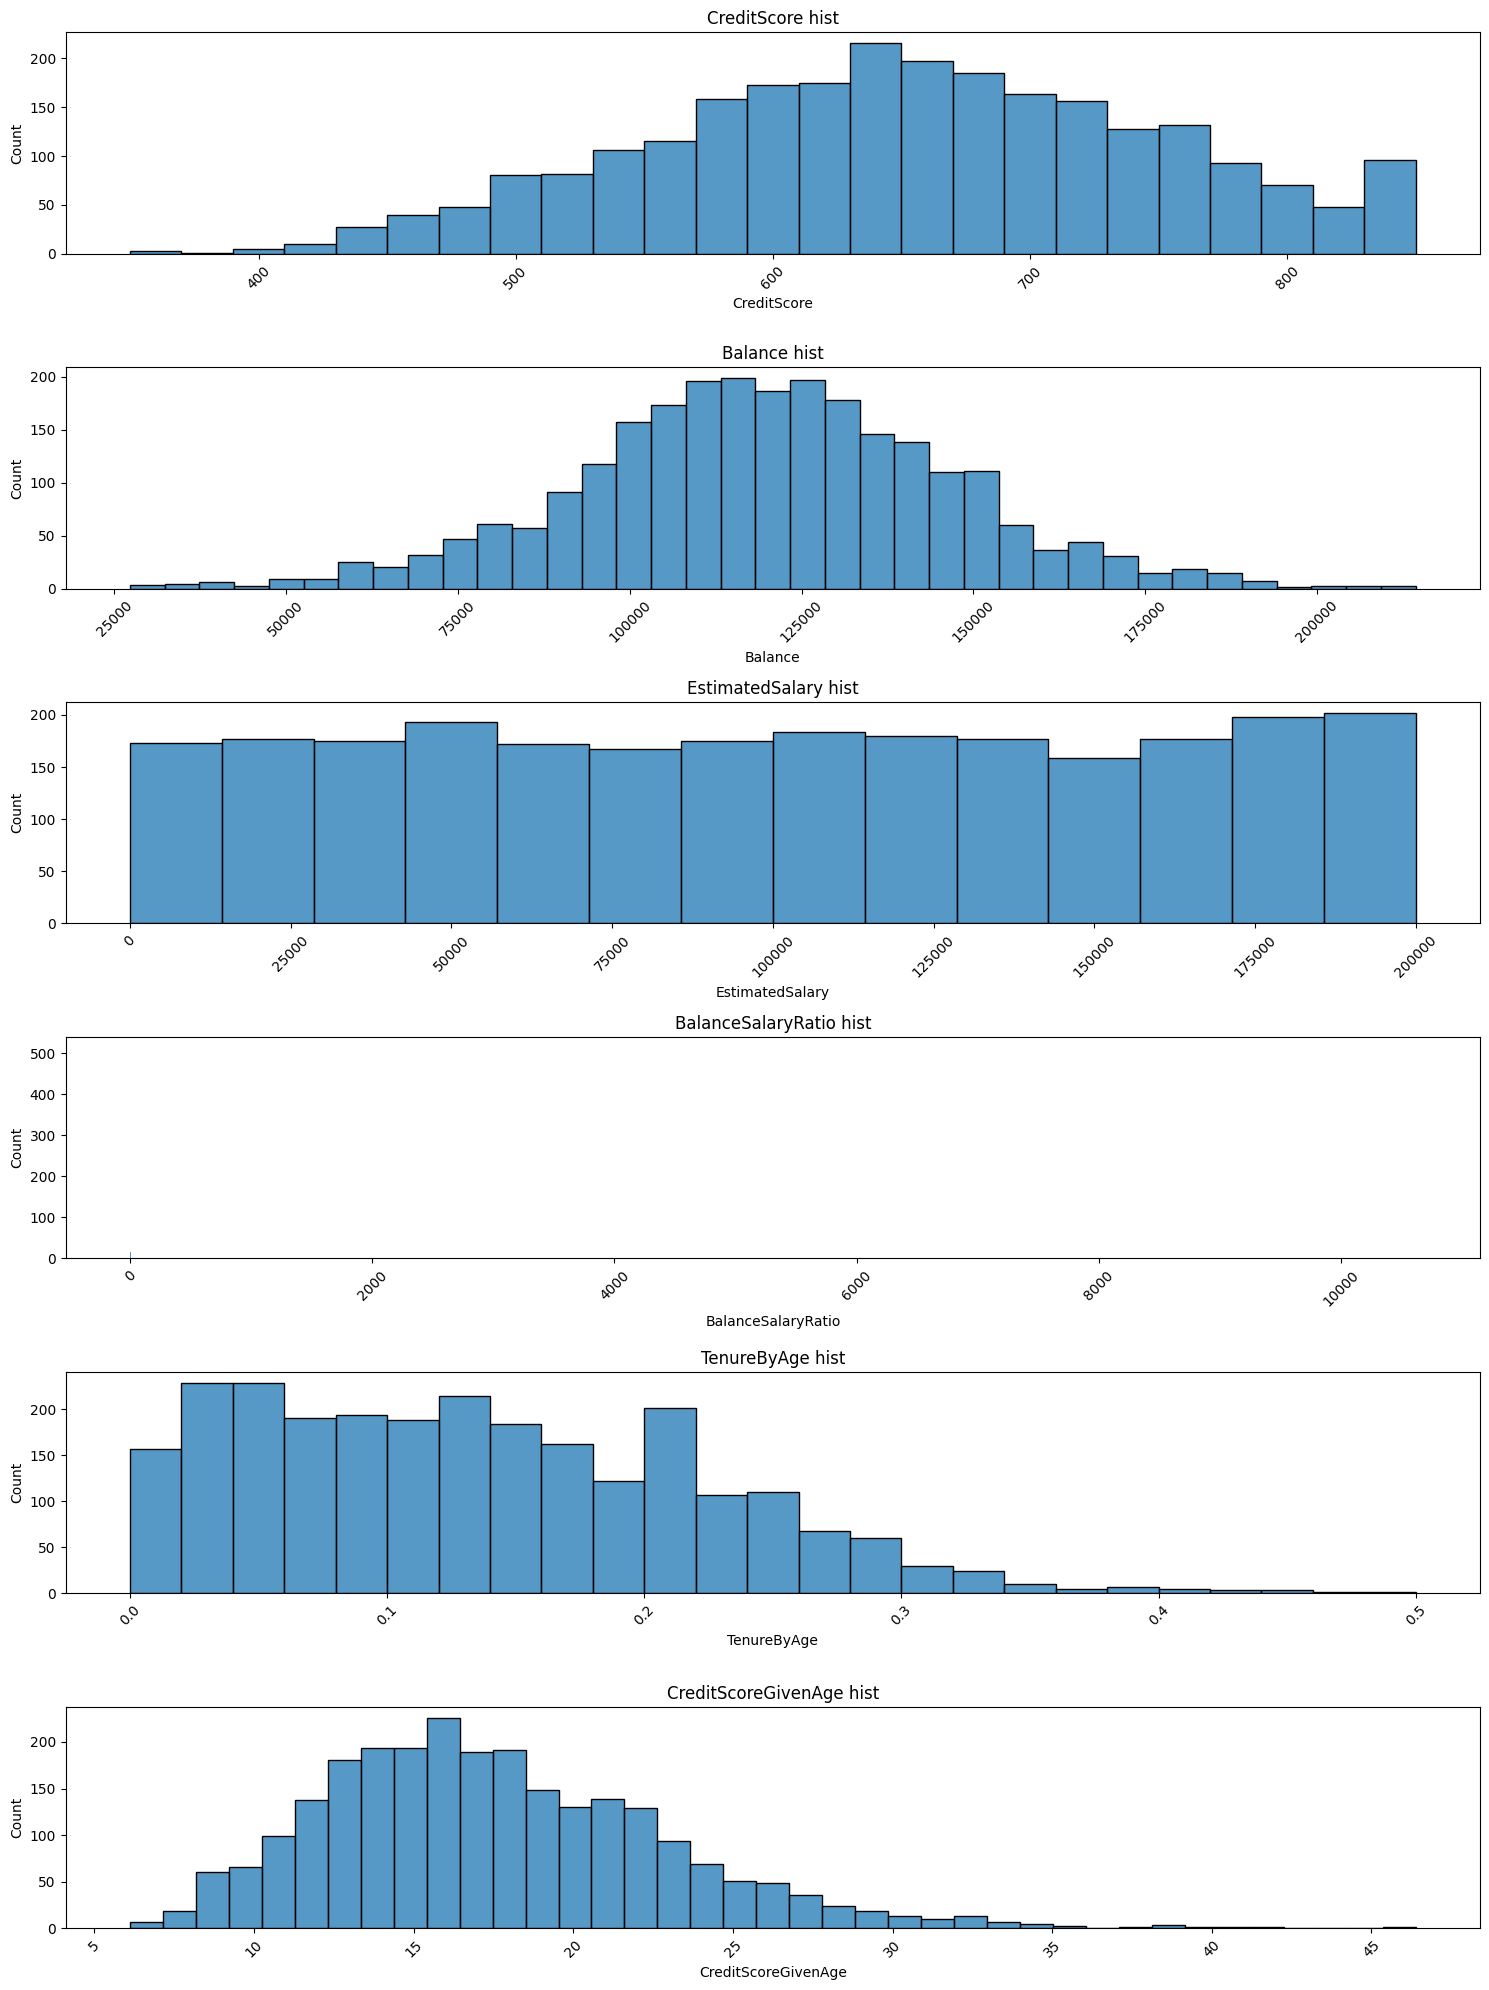

In [213]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 1, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=churn_data, x=feature, ax=axes[i])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [214]:
# Получаем список числовых признаков
num_cat_cols = ['NumOfProducts',
 'IsActiveMember',
 'Exited',
 'Gender_Male']

# Считаем количество уникальных значений для каждого числового признака
churn_data[num_cat_cols].nunique()

NumOfProducts     4
IsActiveMember    2
Exited            2
Gender_Male       2
dtype: int64

---

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [215]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [216]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [217]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 10)
Test shape: (628, 10)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [218]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### 5.2.1 Производим масштабирование данных

In [219]:
# Создаем объект скейлера
scaler = preprocessing.MinMaxScaler()

# Обучаем скейлер на тренировочной выборке
scaler.fit(X_train)

# Трансформируем тренировочные данные
X_train_scaled = scaler.transform(X_train)

# Трансформируем тестовые данные
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


*F1-МЕРА: т.к. надо минимизировтаь как ложноположительные и ложноотрицательные срабатывания модели*

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

*F1-МЕРА используется в задачах, где необходимо балансировать между precision и recall. В свою очередь PRECISION (ТОЧНОСТЬ) используется в задачах, где важно минимальное количество ложноположительных срабатываний модели, а RECALL (ПОЛНОТА) используется в задачах, где важно охватить как можно больше объектов положительного класса (1), то есть уменьшить количество ложноотрицательных срабатываний.*


### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### 5.4.1 Модель логистической регрессии

In [220]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X_train_scaled, y_train)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [0.83942161]
w1, w2: [[ 1.49750094  0.37957514 -0.8070875  -0.08133691 -0.91160027 -0.20920031
   0.43803151 -0.51881061 -5.94779243 -0.43577466]]


#### 5.4.2 Строим предсказания

In [221]:
#Делаем предсказание вероятностей на тренировочной выборке
y_train_proba_predict = log_reg_2d.predict_proba(X_train_scaled)
print('Predicted probabilities: {}'.format(np.round(y_train_proba_predict, 2)))

#Делаем предсказание класса:
y_train_predict = log_reg_2d.predict(X_train_scaled)
print('Predicted class: {}'.format(y_train_predict))

Predicted probabilities: [[0.37 0.63]
 [0.81 0.19]
 [0.97 0.03]
 ...
 [0.38 0.62]
 [0.52 0.48]
 [0.91 0.09]]
Predicted class: [1 0 0 ... 1 0 0]


In [222]:
#Делаем предсказание вероятностей на тестовой выборке
y_test_proba_predict = log_reg_2d.predict_proba(X_test_scaled)
print('Predicted probabilities: {}'.format(np.round(y_test_proba_predict, 2)))

#Делаем предсказание класса:
y_test_predict = log_reg_2d.predict(X_test_scaled)
print('Predicted class: {}'.format(y_test_predict))

Predicted probabilities: [[0.59 0.41]
 [0.44 0.56]
 [0.86 0.14]
 ...
 [0.89 0.11]
 [0.88 0.12]
 [0.95 0.05]]
Predicted class: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

#### 5.4.3 Расчёт выбранной метрики F1-МЕРА на тренировочных и тестовых данных

In [223]:
#Рассчитываем F1-меру на тренировочных данных
print('F1 score (train) : {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))

#Рассчитываем F1-меру на тестовых данных
print('F1 score (test) : {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))

F1 score (train) : 0.47
F1 score (test) : 0.45


**Выводы:**

*- Выбранная метрика F1, что на тренировочных данных, что на тестовых данных < 0.5. Поэтому модель нас не удовлетворяет (считается, недообученной)*

#### 5.4.4 Дополнительное задание

In [224]:
# Определение значений для перебора
C_values = np.arange(0.01, 15, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

best_f1 = 0
best_params = {}

# Перебор параметров

for C in C_values:
    # Инициализация модели
    model = linear_model.LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
    model.fit(X_train_scaled, y_train)  # Обучение модели
    
    # Предсказание
    y_pred = model.predict(X_test_scaled)
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'penalty': 'l1', 'C': C}


# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Лучшие параметры: {'penalty': 'l1', 'C': 9.81}
Лучший F1 score: 0.4942528735632184


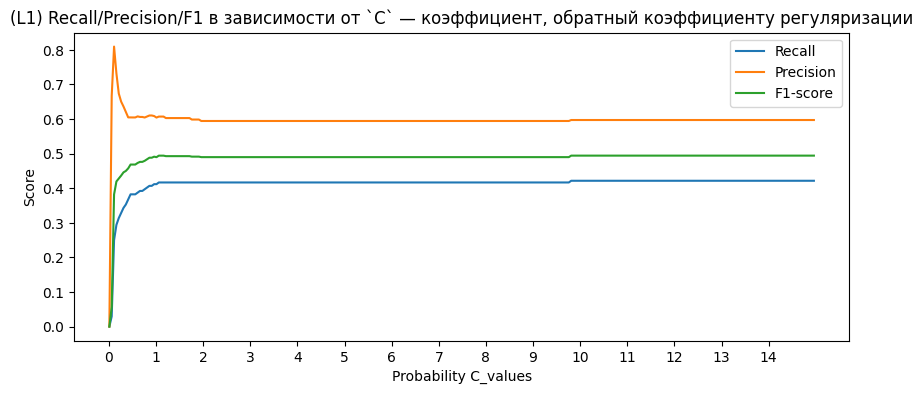

In [225]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(C_values, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(C_values, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(C_values, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('(L1) Recall/Precision/F1 в зависимости от `C` — коэффициент, обратный коэффициенту регуляризации')
ax.set_xlabel('Probability C_values')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(C_values) 
#Устанавливаем отметки по оси x
x_ticks = np.arange(0, 15, 1)  
ax.set_xticks(x_ticks)
#Отображаем легенду
ax.legend();

In [226]:
# Определение значений для перебора
C_values = np.arange(0.01, 15, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

best_f1 = 0
best_params = {}

# Перебор параметров

for C in C_values:
    # Инициализация модели
    model = linear_model.LogisticRegression(penalty='l2', C=C, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
    model.fit(X_train_scaled, y_train)  # Обучение модели
    
    # Предсказание
    y_pred = model.predict(X_test_scaled)
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'penalty': 'l2', 'C': C}


# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Лучшие параметры: {'penalty': 'l2', 'C': 8.71}
Лучший F1 score: 0.4927536231884058


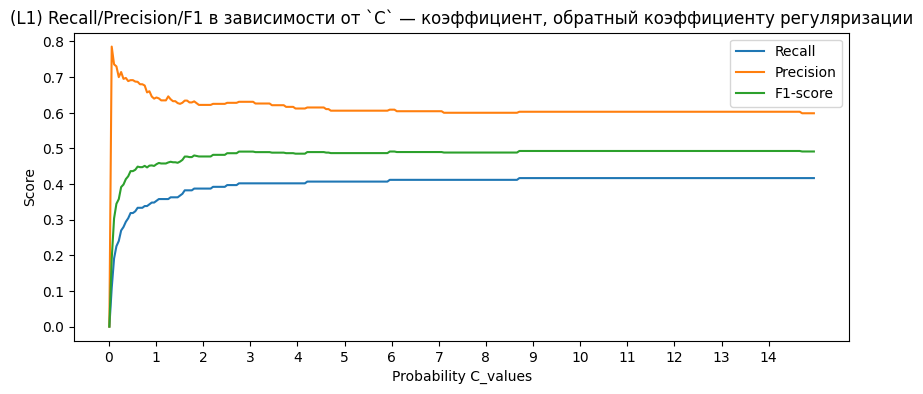

In [227]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(C_values, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(C_values, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(C_values, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('(L1) Recall/Precision/F1 в зависимости от `C` — коэффициент, обратный коэффициенту регуляризации')
ax.set_xlabel('Probability C_values')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
x_ticks = np.arange(0, 15, 1)  
ax.set_xticks(x_ticks)
#Отображаем легенду
ax.legend();

In [228]:
model = linear_model.LogisticRegression(penalty='l1', C=9.81, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
model.fit(X_train_scaled, y_train)  # Обучение модели


LogisticRegression(C=9.81, penalty='l1', random_state=42, solver='liblinear')

In [229]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = model.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



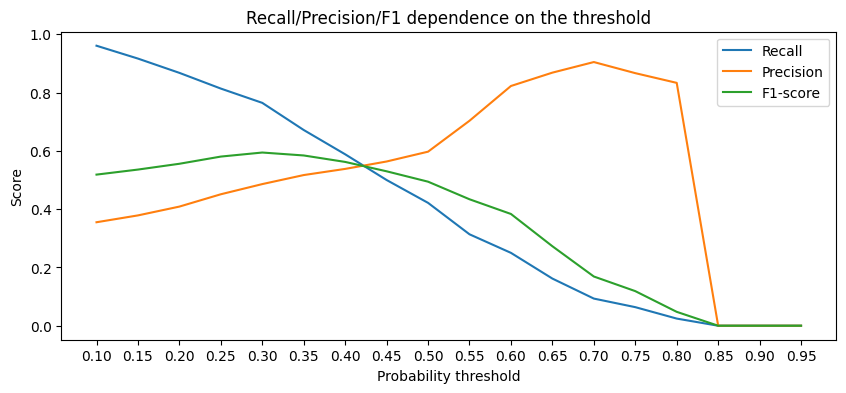

In [230]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [231]:
# Получение вероятностей
probabilities = model.predict_proba(X_test_scaled)[:, 1] # Вероятности положительного класса

# Установка нового порога
threshold = 0.3
predictions = (probabilities >= threshold).astype(int)

# Оценка модели
f1 = metrics.f1_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)

print(f'F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

F1 Score: 0.5942857142857143, Precision: 0.48598130841121495, Recall: 0.7647058823529411


**Дополнительный вывод:** 
Максимального $F_1$-меры достигается в точке — `threshold=0.30` 
с параметрами `C=9.81` и `penalty= L_1-регуляризация`

---

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### 5.5.1 Генерация полиномиальных признаков третьей степени

In [232]:
#Создаем объект для генерации полиномиальных признаков степени 3
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1881, 285)
Test shape: (628, 285)


#### 5.5.2 Построение модели логистической регрессии на полиномиальных признаках

In [233]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X_train_scaled_poly, y_train)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [0.58380153]
w1, w2: [[-1.77958979e-02  2.00821917e+00 -2.65364813e+00 -4.24305920e-02
  -3.40361651e-01 -2.80773073e-01  1.21389979e-01 -1.02452748e+00
  -2.50243492e+00 -8.46709998e-02  1.31544514e-01  1.21550934e+00
  -1.01979774e+00  1.17961295e-01 -1.81220472e-01  1.38166043e-01
   7.41674286e-02  4.52883009e-01 -9.13259541e-01 -2.53705888e-01
  -8.54446491e-01 -9.54148951e-01  6.88817769e-01  4.43025305e-01
   2.69635225e-01  6.15368430e-02  1.23420455e-01 -5.04834284e-01
   6.58934633e-01  3.01340960e+00 -5.86476547e-01 -4.34363905e-01
  -7.39982646e-01  1.36755556e-03 -3.72562886e-01 -8.13165271e-01
  -5.22878822e-01 -4.24305920e-02  2.02826398e-02 -1.12432885e-01
   9.85898460e-02 -1.29885449e-01 -8.97712730e-01  1.53123576e-01
  -3.40361651e-01 -7.03575030e-02  1.37532296e-01 -1.45148049e-01
  -1.29558294e-01 -8.25493209e-02  2.77169290e-02  1.76594789e-04
  -4.91218876e-02 -1.19013539e+00 -4.11234063e-02  1.23248849e-01
   2.62059145e-02  2.20951082e-02  1.34435802e-01 -

#### 5.5.3 Предсказания на тренировочной и тестовой выборках

In [234]:
#Делаем предсказание вероятностей на тренировочной выборке
y_train_proba_predict = log_reg_2d.predict_proba(X_train_scaled_poly)
print('Predicted probabilities: {}'.format(np.round(y_train_proba_predict, 2)))

#Делаем предсказание класса:
y_train_predict = log_reg_2d.predict(X_train_scaled_poly)
print('Predicted class: {}'.format(y_train_predict))

Predicted probabilities: [[0.22 0.78]
 [0.86 0.14]
 [0.97 0.03]
 ...
 [0.48 0.52]
 [0.47 0.53]
 [0.91 0.09]]
Predicted class: [1 0 0 ... 1 1 0]


In [235]:
#Делаем предсказание вероятностей на тестовой выборке
y_test_proba_predict = log_reg_2d.predict_proba(X_test_scaled_poly)
print('Predicted probabilities: {}'.format(np.round(y_test_proba_predict, 2)))

#Делаем предсказание класса:
y_test_predict = log_reg_2d.predict(X_test_scaled_poly)
print('Predicted class: {}'.format(y_test_predict))

Predicted probabilities: [[0.68 0.32]
 [0.54 0.46]
 [0.95 0.05]
 ...
 [0.77 0.23]
 [0.86 0.14]
 [0.9  0.1 ]]
Predicted class: [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 

#### 5.5.4 Расчёт выбранной метрики на тренировочных и тестовых данных

In [236]:
#Рассчитываем F1-меру на тренировочных данных
print('F1 score (train) : {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))

#Рассчитываем F1-меру на тестовых данных
print('F1 score (test) : {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))

F1 score (train) : 0.63
F1 score (test) : 0.61


**Выводы:**

*- Выбранная метрика F1 в пределах `0.5 < F1 score (train,test) < 0.7`. Это лучше чем без генерации полиномиальных признаков, но указывает на необходимость улучшения модели.*

*- F1 score (train) и F1 score (test) имеют близкие значения, что указывает на то, что модель не переобучается и показывает схожие результаты на обоих наборах данных*

#### 5.5.5 Дополнительное задание

In [237]:
# Определение значений для перебора
C_values = np.arange(0.8, 10, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

best_f1 = 0
best_params = {}

# Перебор параметров

for C in C_values:
    # Инициализация модели
    model = linear_model.LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
    model.fit(X_train_scaled_poly, y_train)  # Обучение модели
    
    # Предсказание
    y_pred = model.predict(X_test_scaled_poly)
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'penalty': 'l1', 'C': C}


# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

Лучшие параметры: {'penalty': 'l1', 'C': 2.5500000000000016}
Лучший F1 score: 0.6702412868632708


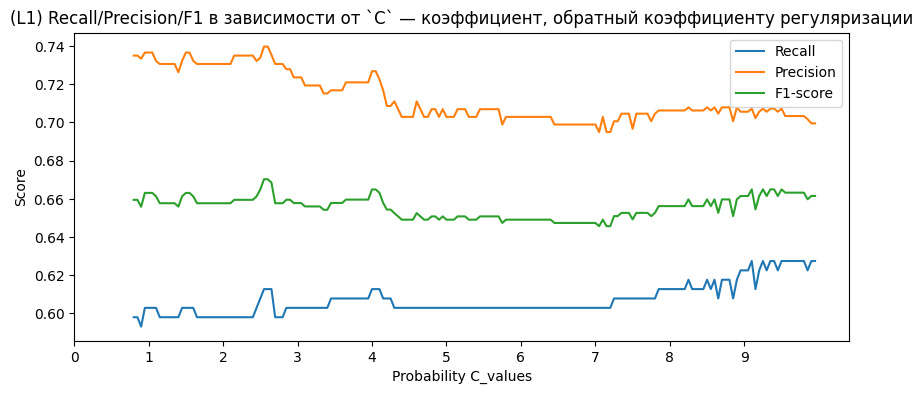

In [238]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(C_values, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(C_values, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(C_values, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('(L1) Recall/Precision/F1 в зависимости от `C` — коэффициент, обратный коэффициенту регуляризации')
ax.set_xlabel('Probability C_values')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(C_values) 
#Устанавливаем отметки по оси x
x_ticks = np.arange(0, 10, 1)  
ax.set_xticks(x_ticks)
#Отображаем легенду
ax.legend();

In [239]:
# Определение значений для перебора
C_values = np.arange(0.8, 10, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

best_f1 = 0
best_params = {}

# Перебор параметров

for C in C_values:
    # Инициализация модели
    model = linear_model.LogisticRegression(penalty='l2', C=C, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
    model.fit(X_train_scaled_poly, y_train)  # Обучение модели
    
    # Предсказание
    y_pred = model.predict(X_test_scaled_poly)
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'penalty': 'l2', 'C': C}


# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

Лучшие параметры: {'penalty': 'l2', 'C': 7.350000000000006}
Лучший F1 score: 0.6522911051212938


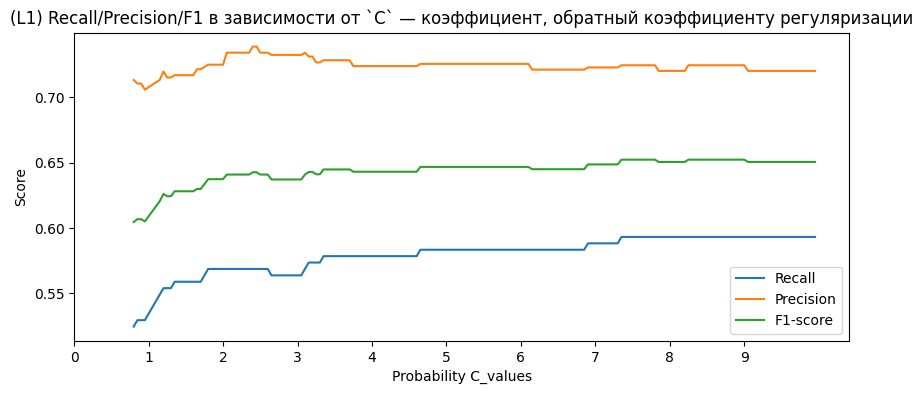

In [240]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(C_values, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(C_values, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(C_values, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('(L1) Recall/Precision/F1 в зависимости от `C` — коэффициент, обратный коэффициенту регуляризации')
ax.set_xlabel('Probability C_values')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
x_ticks = np.arange(0, 10, 1)  
ax.set_xticks(x_ticks)
#Отображаем легенду
ax.legend();

**Дополнительный вывод:** 
Максимального $F_1$-меры достигается в точке
с параметрами `C=2.55` и `penalty= L_1-регуляризация`

---

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### 5.6.1 Расчет модели логистической регрессию, обученную на полиномиальных признаках с подобранным ранее лучшим коэффициентом. 

In [241]:
model = linear_model.LogisticRegression(penalty='l1', C=2.55, solver='liblinear', random_state=42)  # 'liblinear' поддерживает l1 и l2
model.fit(X_train_scaled_poly, y_train)  # Обучение модели

LogisticRegression(C=2.55, penalty='l1', random_state=42, solver='liblinear')

#### 5.6.2 Подбор лучшего порога вероятности

In [242]:
#Считаем вероятности наличия диабета для каждого из пациентов

best_f1 = 0
best_params = {}

#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = model.predict_proba(X_test_scaled_poly)[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'threshold': threshold}
        
        
# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

Лучшие параметры: {'threshold': 0.25000000000000006}
Лучший F1 score: 0.683495145631068


#### 5.6.3 Построение графика зависимости значения выбранной метрики от порога вероятности

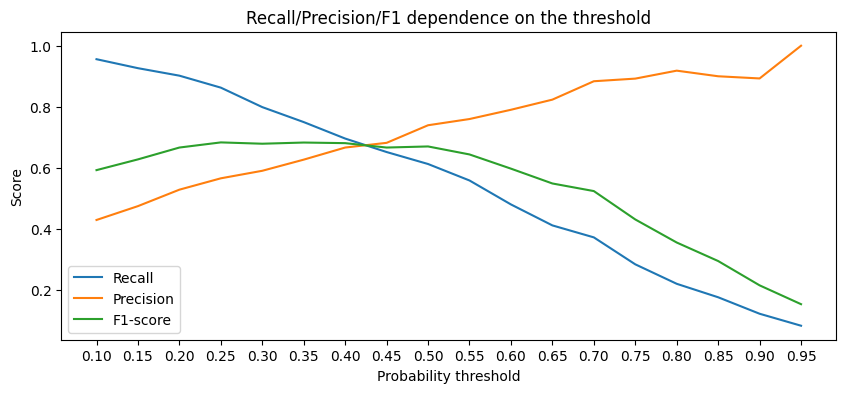

In [243]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

#### 5.6.4 Предсказание классов с подобранным оптимальным порогом вероятности и расчет значения целевой метрики на тестовой выборке.


In [244]:
#Делаем предсказание вероятностей на тренировочной выборке
probabilities = model.predict_proba(X_test_scaled_poly)[:, 1] # Вероятности положительного класса
print('Predicted probabilities: {}'.format(np.round(probabilities, 2)))

#Делаем предсказание класса:
y_train_predict = log_reg_2d.predict(X_train_scaled_poly)
print('Predicted class: {}'.format(y_train_predict))

# Установка нового порога
threshold = 0.25
predictions = (probabilities >= threshold).astype(int)

# Оценка модели
f1 = metrics.f1_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)

print(f'F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

Predicted probabilities: [0.17 0.32 0.03 0.08 0.56 0.05 0.34 0.09 0.86 0.   0.   0.46 0.25 0.37
 0.   0.86 0.16 0.59 0.43 0.02 0.67 0.01 0.22 0.27 0.75 0.31 0.05 0.09
 0.02 0.21 0.27 0.08 0.1  0.13 0.08 0.02 0.64 0.14 0.42 0.16 0.03 0.05
 1.   0.72 0.94 0.2  0.37 0.02 0.29 0.21 0.19 0.   0.22 0.09 0.07 0.04
 0.27 0.18 0.41 0.59 0.15 0.16 1.   0.8  0.76 0.01 0.01 0.06 0.55 0.09
 0.1  0.44 0.23 0.11 0.03 0.01 0.23 0.38 0.56 0.19 0.38 0.27 0.13 0.64
 0.95 0.08 0.15 0.68 0.11 0.39 0.11 0.03 0.26 0.16 0.17 0.14 0.63 0.26
 0.33 0.01 0.9  0.07 0.26 0.75 0.11 0.01 0.47 0.06 0.14 0.07 0.95 0.11
 0.27 0.1  0.01 0.1  0.35 0.85 0.49 0.36 0.07 0.24 0.22 0.18 0.   0.77
 0.1  0.76 0.02 0.24 0.58 0.21 0.3  0.08 0.17 0.28 0.26 0.57 0.09 0.2
 0.12 0.23 0.05 0.12 0.47 0.12 0.3  0.26 0.35 0.5  0.66 0.49 0.74 0.05
 0.97 0.52 0.22 0.36 0.57 0.09 0.29 0.02 0.73 0.42 0.09 0.44 0.7  0.09
 0.81 0.84 0.32 0.08 0.04 0.01 0.35 0.05 1.   0.24 0.21 0.02 0.7  0.17
 0.31 0.99 0.03 0.18 0.49 0.47 0.41 0.71 0.46 0.22 0.

**Вывод:** 
Максимального $F_1$-меры достигается в точке — `threshold=0.25` 
с параметрами `C=2.55` и `penalty= L_1-регуляризация`

За счет регрессии на полиномиальных признаках мы улучшили F1 score с 0.5942 до 0.6834

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [245]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 10)
Test shape: (628, 10)


Импортируем необходимые для выполнения практики модули:

In [246]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### 8.1.1 Построение модель дерева решений `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева

In [247]:
# Создание объекта класса DecisionTreeClassifier с использованием энтропии Шеннона
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его глубины
dt_clf_bad.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

#### 8.1.2 Формирование предсказания для тренировочной и тестовой выборок

In [248]:
#Делаем предсказание класса для тренировочного и тестового набора данных
y_train_pred = dt_clf_bad.predict(X_train)
y_test_pred = dt_clf_bad.predict(X_test)


#### 8.1.3 Расчёт выбранной метрики на тренировочных и тестовых данных 

In [249]:
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       424
           1       0.58      0.58      0.58       204

    accuracy                           0.73       628
   macro avg       0.69      0.69      0.69       628
weighted avg       0.73      0.73      0.73       628



#### 8.1.4 Попробуем визуализировать результат

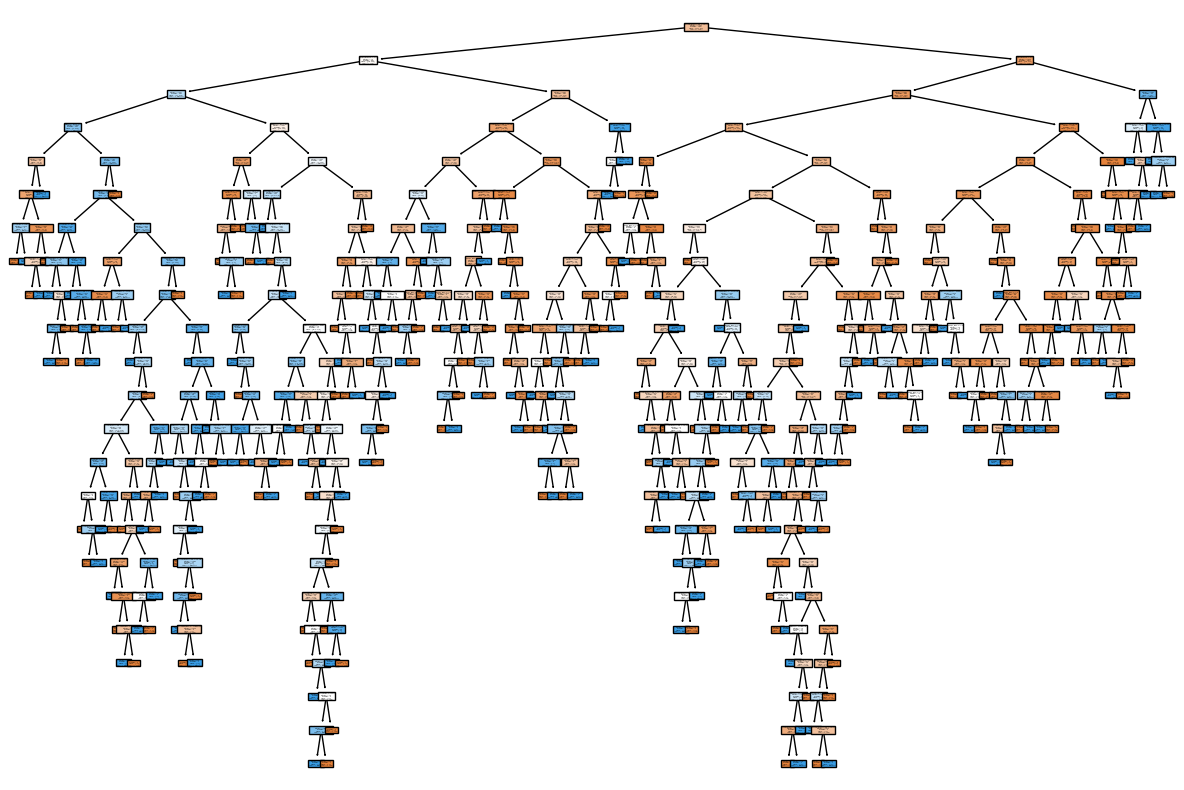

In [250]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - loyal", "1 - departed"], #названия классов
    filled=True, #расцветка графа
);

In [251]:
# Посмотрим получившуюся глубину дерева
dt_clf_bad.get_depth()

22

**Вывод:** - *Мы видем переобучение дерева решений, т.к. дерево глубиной 22 задаёт огромное количество вопросов для того, чтобы предсказать отток клиентов*

---

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### 8.2.1 Строим модель дерева решений с заданными в условии задачи параметрами

In [252]:
# Создание объекта класса DecisionTreeClassifier с использованием энтропии Шеннона
dt_clf_good = tree.DecisionTreeClassifier(
    criterion='entropy', # Критерий информативности - энтропия Шеннона
    random_state=42, #генератор случайных чисел
    max_depth=8,  # Максимальная глубина дерева
    min_samples_leaf=10  # Минимальное число объектов в листе
)
#Обучаем дерево решений по алгоритму CART без ограничения его глубины
dt_clf_good.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       random_state=42)

#### 8.2.2 Формируем предсказания для тренировочной и тестовой выборок

In [253]:
#Делаем предсказание класса для тренировочного и тестового набора данных
y_train_pred = dt_clf_good.predict(X_train)
y_test_pred = dt_clf_good.predict(X_test)

#### 8.2.3 Расчет метрики

In [254]:
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1271
           1       0.75      0.72      0.74       610

    accuracy                           0.83      1881
   macro avg       0.81      0.80      0.81      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       424
           1       0.67      0.62      0.65       204

    accuracy                           0.78       628
   macro avg       0.75      0.74      0.74       628
weighted avg       0.78      0.78      0.78       628



#### 8.2.4 Попробуем визуализировать результат

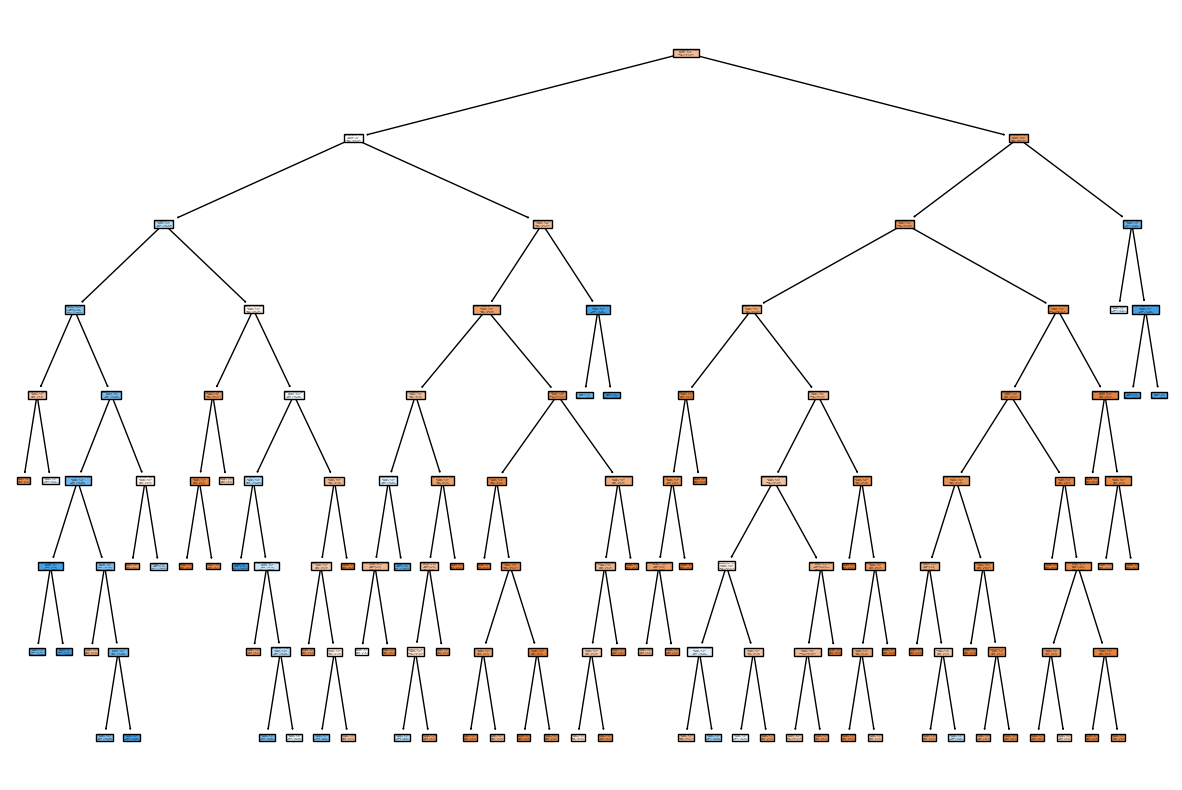

In [255]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_good, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - loyal", "1 - departed"], #названия классов
    filled=True, #расцветка графа
);

> **Вывод** - *Метрика F1 улучшилась по сравнению с обучением безограничения глубины и без задания количества объектов, при которых дерево прекратит делиться и образуется лист. Также мы не наблюдаем переобучение, но значение F1 = 0.65 не сильно превышает значение, полученное в предыдущих эксперементах с регрессией на полиномиальных признаках*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### 8.3.1 Строим случайный лес решений с заданными в условии задачи параметрами

In [256]:
#Создаём объект класса случайный лес
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42, #генератор случайных чисел
    min_samples_leaf=10  # Минимальное число объектов в листе
)
#Обучаем модель 
rf_clf_full.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=500, random_state=42)

#### 8.3.2 Формируем предсказания для тренировочной и тестовой выборок

In [257]:
#Делаем предсказание класса для тренировочного и тестового набора данных
y_train_pred = rf_clf_full.predict(X_train)
y_test_pred = rf_clf_full.predict(X_test)

#### 8.3.3 Производим расчёт выбранной метрики на тренировочных и тестовых данных

In [258]:
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      1271
           1       0.86      0.64      0.73       610

    accuracy                           0.85      1881
   macro avg       0.85      0.79      0.81      1881
weighted avg       0.85      0.85      0.84      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.72      0.56      0.63       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



> **Вывод:** - *По сравнению с методом DecisionTreeClassifier (`F1=0,74`), метод RandomForestClassifier (`F1=0.73`) дал незначительно худший результат. Предположительно, что на результаты повлияли выбранные параметры*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

#### 8.4.1 Подбираем значения для метода DecisionTreeClassifier

In [259]:
# Определение диапазонов параметров для перебора
max_depths = [5, 8, 10, 12, 15]
min_samples_leaves = [1, 5, 10, 15]

best_f1_score = 0
best_params = {}

# Перебор параметров
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leaves:
        # Инициализация модели с текущими параметрами
        model = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        
        # Обучение модели
        model.fit(X_train, y_train)
        
        # Предсказание на тестовых данных
        y_pred = model.predict(X_test)
        
        # Вычисление точности
        f1_score = metrics.f1_score(y_test, y_pred)
        
        # Проверка на лучшее значение точности
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Вывод лучших параметров и точности
print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_f1_score)# Ваш код здесь

Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 1}
Лучшая точность: 0.6481012658227848


In [260]:
model = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=42)
# Обучение модели
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1271
           1       0.80      0.75      0.77       610

    accuracy                           0.86      1881
   macro avg       0.84      0.83      0.83      1881
weighted avg       0.86      0.86      0.86      1881

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       424
           1       0.67      0.63      0.65       204

    accuracy                           0.78       628
   macro avg       0.75      0.74      0.74       628
weighted avg       0.78      0.78      0.78       628



#### 8.4.2 Подбор лучшего порога вероятности

In [261]:
#Считаем вероятности наличия диабета для каждого из пациентов

best_f1 = 0
best_params = {}

#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = model.predict_proba(X_test)[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'threshold': threshold}
        
        
# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

Лучшие параметры: {'threshold': 0.5000000000000001}
Лучший F1 score: 0.6481012658227848


#### 8.4.3 Построение графика зависимости значения выбранной метрики от порога вероятности

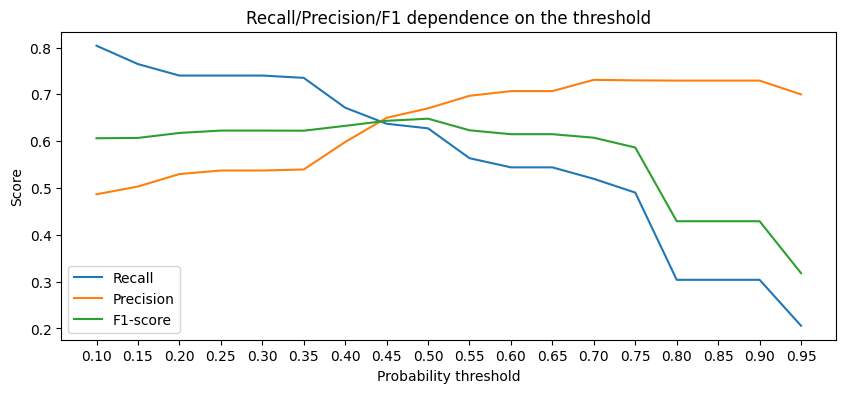

In [262]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

#### 8.4.4 Подбираем значения для метода RandomForestClassifier

In [263]:
# Определение диапазонов параметров для перебора
max_depths = [5, 8, 10, 12, 15]
min_samples_leaves = [1, 5, 10, 15]

best_f1 = 0
best_params = {}

# Перебор параметров

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leaves:
        # Инициализация модели с текущими параметрами
        model = ensemble.RandomForestClassifier(
            n_estimators=500,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
        # Обучение модели
        model.fit(X_train, y_train)
        
        # Предсказание на тестовых данных
        y_pred = model.predict(X_test)
        
        # Вычисление F1-меры
        f1 = metrics.f1_score(y_test, y_pred)
        
        # Проверка на лучшее значение F1-меры
        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf
            }

# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучшая F1-мера:", best_f1)

Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 5}
Лучшая F1-мера: 0.6371191135734072


In [264]:
model = ensemble.RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=5, random_state=42)
# Обучение модели
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1271
           1       0.87      0.68      0.76       610

    accuracy                           0.86      1881
   macro avg       0.87      0.82      0.83      1881
weighted avg       0.86      0.86      0.86      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628



#### 8.4.5 Подбор лучшего порога вероятности

In [265]:
#Считаем вероятности наличия диабета для каждого из пациентов

best_f1 = 0
best_params = {}

#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = model.predict_proba(X_test)[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    
    # Вычисление F1-меры
    f1 = metrics.f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Проверка на лучшее значение F1-меры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'threshold': threshold}
        
        
# Вывод лучших параметров и F1-меры
print("Лучшие параметры:", best_params)
print("Лучший F1 score:", best_f1)

Лучшие параметры: {'threshold': 0.3500000000000001}
Лучший F1 score: 0.6876404494382022


C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



#### 8.4.6 Построение графика зависимости значения выбранной метрики от порога вероятности

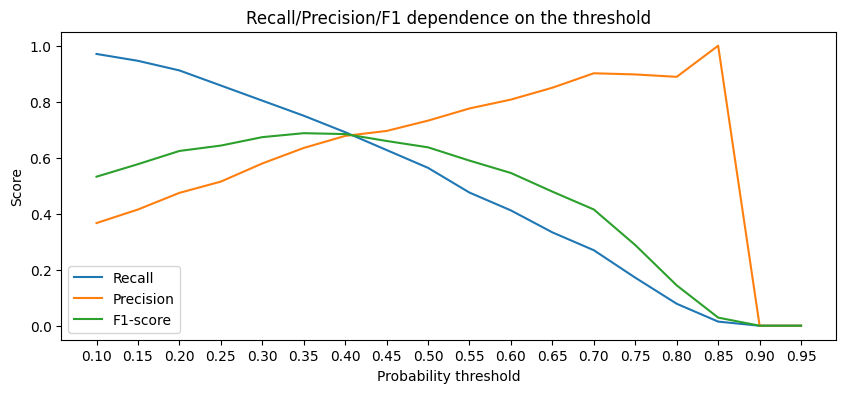

In [266]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

>**ПРОДЕЛАННАЯ РАБОТА:**
- Проведен разведывательный анализ данных (иследования взяты из ранее выполненной работы)
- Созданы новые признаки: 
-- отношение баланса на счетах к заработной плате клиента
-- отношение времени пользования услугами банка к возрасту клиента
-- отношение кредитного рейтинга к возрасту клиента
- Перекодированы категориальные признаки в числовые бинарные столбцы
- Произведен расчет основных статистических характеристик с оценкой мультиколинеарности
- Выбрана метрика F1-МЕРА т.к. надо минимизировтаь как ложноположительные и ложноотрицательные срабатывания модели
- Для модели логистической регрессии произведено масштабирование данных с использованием MinMaxScaler и сгенерированы полиноминальные признаки третьей степени
- Построена модель логистической регрессии и для нее подоброны оптимальные параметры и лучший порог вероятности
- Построена модель дерево решений для нее подоброны оптимальные параметры и лучший порог вероятности
- Построена модель случайный лес и для нее подоброны оптимальные параметры и лучший порог вероятности
- Выбрана наилучшая модель на основе лучшего значения метрики F1

> **ИТОГОВЫЙ ВЫВОД:** - *Из расмотренных моделей наилучший результат с учетом подбора параметров и подбора порога вероятности показала модель RandomForestClassifier (случайный лес). `F1 score = 0.6876`*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### 8.5.1 Формируем DataFrame на основе предоставленного словаря

In [267]:
# Создание словаря
data = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

# Создание DataFrame из словаря
churn_data = pd.DataFrame(data)

# Вывод DataFrame
print(churn_data)

   CreditScore Gender   Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0        601.0   Male  42.0     1.0  98495.72            1.0        1.0   

   IsActiveMember  EstimatedSalary  
0             0.0         40014.76  


#### 8.5.2 Преобразовываем данные, необходимые для работы модели

##### Создаем новые признаки

In [268]:
# Создаем новый признак `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

# Создаем новый признак `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

# Создаем новый признак `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

##### Кодируем категориальных признаков в числовые бинарные столбцы

In [269]:
# Кодирование Gender в Gender_Male
churn_data['Gender_Male'] = churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
churn_data = churn_data.drop('Gender', axis=1)

##### Удаляем ненужные признаки

In [270]:
churn_data = churn_data.drop(['Age', 'Tenure'],axis=1)

#### 8.5.3 Предсказываем вероятность оттока клиента

In [271]:
model = ensemble.RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=5, random_state=42)
# Обучение модели
model.fit(X_train, y_train)



RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=500,
                       random_state=42)

In [272]:
# Без учета выбранного лучшего порога вероятности, с порогом вероятности = 0.5
y_pred = model.predict(churn_data)
display(y_pred)

array([1], dtype=int64)

In [273]:
#Пациентов, для которых вероятность наличия диабета > 0.35 относим к классу 1
#В противном случае — к классу 0
threshold = 0.35

y_proba_pred = model.predict_proba(churn_data)

# Предположим, что мы хотим использовать вероятности для положительного класса (обычно это второй столбец)
y_proba_positive = y_proba_pred[:, 1]  # Получаем вероятности для класса 1

# Применяем порог для классификации
y_pred = (y_proba_positive > threshold).astype(int)

# Вывод результатов
print("Предсказанные классы:", y_pred)
print("Вероятности:", y_proba_positive)

Предсказанные классы: [1]
Вероятности: [0.73175354]
